# LSTM

Long Short Term memory (LSTM) neural networks architecture that can be applied to time series forecasting. Unlike popular feedforward neural networks, LSTM's contain a feedback connection known as Recurrent Neural Networks (RNN).  This allows the model to learn order dependence in sequences.

RNN's are able to withhold contextual information in a sequence (for time series this would mean past information), and use this contextual information to transform input sequences to output sequences

For additional information on how to build a LSTM, follow the [link](https://keras.io/layers/recurrent/)

Load the the required files and libraries

**NOTE: In order to run these notebooks the following must be installed:**

- keras
- tensorflow

In [1]:
\l ml/ml.q
\l ml/init.q
\l ../utils.q

seq   :.p.import[`keras.models]`:Sequential
lstm  :.p.import[`keras.layers]`:LSTM
dense :.p.import[`keras.layers]`:Dense
npa   :.p.import[`numpy]`:array
bidir :.p.import[`keras.layers]`:Bidirectional

No shared object files for cutils.q, only q implementations available


Using TensorFlow backend.


## Daily Temp


### Data Preparation


The below dataset contains the mimimum daily temperatures reached in Melbourne during the period from January 1981 - Decemeber 1990.

Null values are removed from the dataset

In [2]:
show mintemp:`date`temp xcol ("PF";enlist",")0:`:../data/dailytemp.csv

// Delete any nulls from the data
mintemp:delete from mintemp where temp=0N

date                          temp
----------------------------------
1981.01.01D00:00:00.000000000 20.7
1981.01.02D00:00:00.000000000 17.9
1981.01.03D00:00:00.000000000 18.8
1981.01.04D00:00:00.000000000 14.6
1981.01.05D00:00:00.000000000 15.8
1981.01.06D00:00:00.000000000 15.8
1981.01.07D00:00:00.000000000 15.8
1981.01.08D00:00:00.000000000 17.4
1981.01.09D00:00:00.000000000 21.8
1981.01.10D00:00:00.000000000 20  
1981.01.11D00:00:00.000000000 16.2
1981.01.12D00:00:00.000000000 13.3
1981.01.13D00:00:00.000000000 16.7
1981.01.14D00:00:00.000000000 21.5
1981.01.15D00:00:00.000000000 25  
1981.01.16D00:00:00.000000000 20.7
1981.01.17D00:00:00.000000000 20.6
1981.01.18D00:00:00.000000000 24.8
1981.01.19D00:00:00.000000000 17.7
1981.01.20D00:00:00.000000000 15.5
..


Arima does not account for missing timestamps, these values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [3]:
mintemp:datefill[`date;mintemp;1D]

// Back and forward fill the missing data
mintemp:.ml.filltab[mintemp;();`date;::]

The data is plotted below to portray the trends and cycles present in the dataset

/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


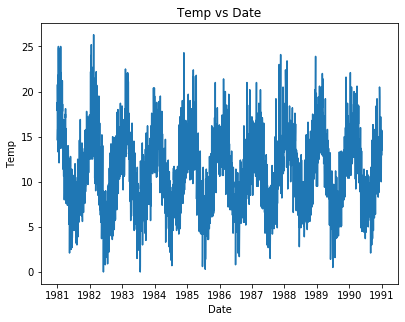

In [4]:
plttm[mintemp`date;mintemp`temp;"Temp"]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

Because this is a univariate problem, a lagged version of the target values are used as the input values. Transforming these input values into the appropriate format is detailed in sections to follow

In [5]:
// Find the timestamp which splits the data 80/20
tts:ttstm[mintemp`temp;mintemp`temp;0.2]

// The data is then split into the training and testing sets
xtraintmp:tts`xtrain
ytraintmp:tts`ytrain
xtesttmp:tts`xtest
ytesttmp:tts`ytest


-1!"There is ",string[count xtraintmp]," datapoints in the training set"
-1!"There is ",string[count xtesttmp]," datapoints in the testing set"

"There is 2921 datapoints in the training set"


"There is 731 datapoints in the testing set"


### Training the model

A vanilla LSTM is inialised below to demonstrate how an LSTM can easily be built. This is a Sequential model which contains a single dense layer and output layer used to make predictions. A ReLu activation function is utilised with adam optimiser and mean squared error used as the loss. The two variables that need to be set in the model are:

- `n_feats`: number of input features being passed to the model
- `n_steps`: The amount of previous time steps to include (lagged data)

This is a univariate time series, so the number of features is set to 1, and steps equal to 3

In [6]:
// Define feat and step count
n_feat:count xtraintmp[0]
n_steps:3;

// Initialise a sequential model
mdltmp:seq[];
//Add the LSTM with relu activation
mdltmp[`:add][lstm[50;`activation pykw `relu;`input_shape pykw(n_steps;n_feat)]];
mdltmp[`:add][dense[1]];
mdltmp[`:compile][`optimizer pykw `adam;`loss pykw `mse];

2020-04-02 10:33:47.031007: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-02 10:33:47.050849: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc14b22c920 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-02 10:33:47.050889: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Before the model is fitted, the data must be reshaped in order to be passed to the LSTM model. The reshapeing requires the data to be in the following format:

 `(number of samples, timesteps, features)`
 
 This can be done using the function `reshape` function, which takes 3 inputs,
 
 - `data` : The data to be transformed
 - `n_steps` : The number of time steps
 - `n_feat` :number of features
 
As this is a univariate problem, lagged predicted values will be used as the input to the problem

In [7]:
datatmp:reshape[xtraintmp;ytraintmp;n_steps;n_feat]

The model is then fitted on the transformed training input data, along with the target training data

In [8]:
mdltmp[`:fit][datatmp`xdata;datatmp`ydata;`epochs pykw 20;`verbose pykw 0];

### Model Forecasting

The testing data is also transformed into the appropriate format using the above reshape formula, with the appropriate time_steps applied

In [9]:
tsttmp:reshape[xtesttmp;ytesttmp;n_steps;n_feat]

The model is then used to forecast the future values, and the error is calculated

In [10]:
// Future forecasts are made
predstmp:raze "f"$mdltmp[`:predict][tsttmp`xdata]`

// Calculate the error
-1!"The Mean squared error is ",string .ml.mse[predstmp;tsttmp`ydata]

"The Mean squared error is 7.687669"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values

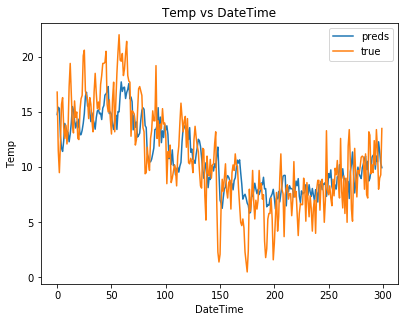

In [11]:
pltresult[300#predstmp;300#tsttmp`ydata;"Temp"]

From the above plot, it is evident that the LSTM was able to capture the over all trend of the time series and could estimate the values reached by the peaks and troughs of the dataset. 

## Bike Rental

**In this section a more complex model is used with exogenous variables included in the training of the models**

### Data Preparation

Load in the data

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [12]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The trends over time for the data is plotted below which shows that cyclical patterns are present in the dataset

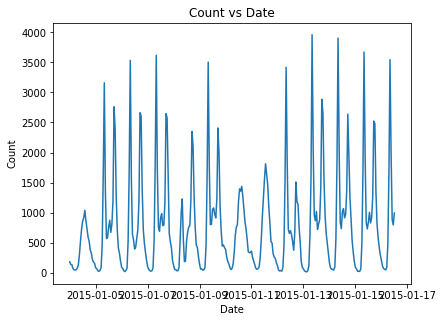

In [13]:
plttm[300#bikes`timestamp;300#bikes`cnt;"Count"]

Arima does not account for missing timestamps, these values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [14]:
// Include any missing datetimes
bikes:datefill[`timestamp;bikes;01:00:00.000]

// Back and forward fill the missing data
bikes:.ml.dropconstant[.ml.filltab[bikes;();`timestamp;::]]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

As there is multiple input columns, this is defined as a multivariate problem. The input values will be lagged values of the exogenous columns. The timestamp column will be removed from the dataset.

Further preprocessing will be applied to the training and testing dataset in later sections, similar to the previous example.

In [15]:
// Find the timestamp which splits the data 80/20
tts:ttstm[flip value flip delete cnt,timestamp from bikes;bikes`cnt;0.2]

// The data is then split into the training and testing sets
xtrainbk:tts`xtrain
ytrainbk:tts`ytrain
xtestbk:tts`xtest
ytestbk:tts`ytest


-1!"There is ",string[count xtrainbk]," datapoints in the training set"
-1!"There is ",string[count xtestbk]," datapoints in the testing set"

"There is 14035 datapoints in the training set"


"There is 3509 datapoints in the testing set"


### Training the model

A Bidirectional LSTM is applied below. This is an extension on the ordinary LSTM, which in some circumstances can improve the results. A bidirectional LSTM, applied the LSTM twice, one on the normal data, and another on the data reversed. These results are then concatenated together. This has the ability to improve the results by supplying more context to the model

The inputs to the bidirectional model are similar to above, but with one additional component, a bidirectional layer is also included when building the LSTM layer.

As this is not a univariate problem, the `n_feat` is set to be the number of columns from the dataset that will be passed to the model, and `n_steps` will be increased to 4.

In [16]:
n_steps:4
n_feat:count xtrainbk[0]

// Initialise a sequential model
mdlbk:seq[];
//Add the LSTM with relu activation
mdlbk[`:add][bidir[lstm[50;`activation pykw `relu;`input_shape pykw(n_steps;n_feat)]]];
mdlbk[`:add][dense[1]];
mdlbk[`:compile][`optimizer pykw `adam;`loss pykw `mse];

Similar to above, the data must be reshaped to be in an appropraite to pass to the LSTM. The `reshape` function is utilised to achieve this, passing in the `n_steps` and `n_feat` values in order to extract the lagged values

In [17]:
databk:reshape[xtrainbk;ytrainbk;n_steps;n_feat]

The model is then fitted on the transformed training input data, along with the target training data

In [18]:
mdlbk[`:fit][databk`xdata;databk`ydata;`epochs pykw 15;`verbose pykw 0];

### Model Forecasting

The testing data is also transformed into the appropriate format using the above reshape formula, with the appropriate time_steps applied

In [19]:
tstbk:reshape[xtestbk;ytestbk;n_steps;n_feat]

The model is then used to forecast the future values, and the error is calculated

In [20]:
// Future forecasts are made
predsbk:raze "f"$mdlbk[`:predict][tstbk`xdata]`

// Calculate the error
-1!"The Root Mean Squared Log Error is ",string .ml.rmsle[predsbk;tstbk`ydata]

"The Root Mean Squared Log Error is 1.198737"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values

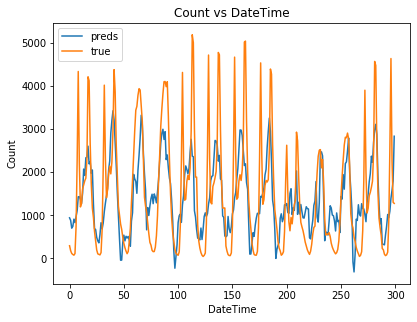

In [21]:
pltresult[300#predsbk;300#tstbk`ydata;"Count"]

The forecasted results are very similar to the real values, correctly predicting the correct areas where the data peaks, however overreaches values in certain areas